In [261]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

from scipy.fft import rfft, irfft, rfftfreq

In [277]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../analysis_utils.py'>

In [220]:
c = 299792458  # m/s
SI2ev = (1 / 1.6e-19) * c

#### Calibrate the displacement noise

In [343]:
sphere = 'sphere_20260105'
folder = '20260107_electric_calibration_4e-8mbar_0'
file_prefix_0_5v = '20260107_d_p8e_117khz_0.5vpp_lensholder1'
file_prefix_1v = '20260107_d_p8e_117khz_1vpp_lensholder1'

c_mvs_all = []
vpps = [0.5, 1]
for i, file_prefix in enumerate([file_prefix_0_5v, file_prefix_1v]):
    _files = [rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_0.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_1.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_2.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_3.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_4.hdf5']

    c_mvs = utils.get_c_mv(_files, vp2p=[vpps[i], vpps[i], vpps[i], vpps[i], vpps[i]], omegad=117000*2*np.pi, passband=(116900, 117100), searchband=(45000, 55000), charge=8, n_chunk=1, efield=138, sphere_radius=50e-9)
    c_mvs_all.append(c_mvs)

c_mv = np.mean(np.asarray(c_mvs_all))
print(f'c_mv: {c_mv}')

c_mv: 3.620829311453009e-07


Text(0, 0.5, 'PSD (V$^2$/Hz)')

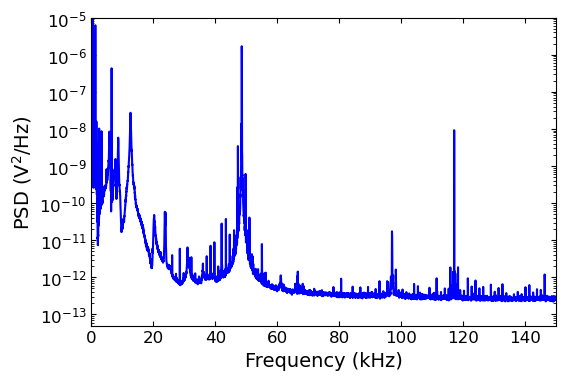

In [326]:
file_prefix = '20260107_d_p8e_117khz_1vpp_lensholder1'
_file = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_4.hdf5'

dtt, dd = utils.load_timestreams(_file, ['D'])
zz = dd[0]
ff, pp = utils.get_psd(dt=dtt, zz=zz, nperseg=2**18)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(ff/1000, pp, 'b')
plt.yscale('log')

plt.xlim(0, 150)
plt.ylim(5e-14, 1e-5)
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (V$^2$/Hz)')

#### Fit the resonance for the mechanical response

Delta_p: 49.23885647151293 keV/c


(0.0, 120.0)

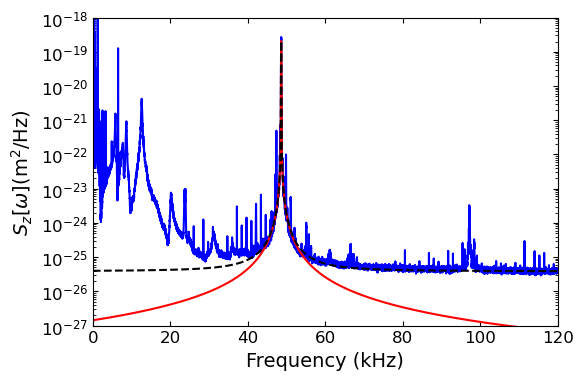

In [348]:
_file = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/20260107_d_p8e_nodrive_4.hdf5'
ff, sz_measured, sf_measured, chi_2_convolved, dp_kev, fig, ax, voigt = utils.get_effective_force_noise(_file, c_mv, int_band=(30000, 90000), 
                                                                                                        fit_band=(44000, 60000), nperseg=2**19, plot_fit=True,
                                                                                                        p0=[2e-19, 48381*2*np.pi, 100*2*np.pi, 5*2*np.pi],
                                                                                                        sphere_radius=50e-9)
print(f'Delta_p: {dp_kev} keV/c')

_idx = np.logical_and(ff>110000, ff<150000)
sz_imp = np.mean(sz_measured[_idx])

ax.plot(ff/1000, voigt+sz_imp, 'k--')
ax.set_ylim(1e-27, 1e-18)
ax.set_xlim(0, 120)

#### Calculate the theory predicted backaction and thermal force noise

In [349]:
# Find the resonant frequency from measured displacement noise
_idx = np.logical_and(ff>40000, ff<90000)
omega0 = ff[_idx][np.argmax(sz_measured[_idx])] * 2 * np.pi

In [350]:
rho = 2000 # kg/m^3
m = rho * (50e-9)**3 * 4 * np.pi / 3

c = 299792458  # m/s
kb = 1.38e-23
hbar = 1.054571817e-34

def get_c_d_integrals(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    
    return C, D

def calc_geometric_factor(na):
    """Calculate the geometric factor A using Eq. (A3), (E2a) and (E2b) of https://arxiv.org/pdf/1907.12838.pdf"""
    C, D = get_c_d_integrals(na)
    return D / C

na = 0.77
lambd = 1064e-9
k = 2 * np.pi / lambd

A = calc_geometric_factor(na=na)
_p_sca = 40.999e-6 * (omega0/(2*np.pi)/49964.63)**2 * (100/166)**3  # W
_s_ff_ba = ((A**2 + 2/5) * hbar * k / c) * _p_sca
_gamma_ba = _s_ff_ba / (2 * m * omega0 * hbar)
_s_zz_imp = (hbar**2 / 4) / _s_ff_ba

print(f'Scattered laser power (theory) = {_p_sca * 1e6:.2f} uW')
print(f'Backaction heating rate (theory): 2 pi x {_gamma_ba/1000/(2*np.pi):.3f} kHz')
print(f'Backaction noise (double-sided, theory): {_s_ff_ba:.3e} N^2/Hz')
print(f'Imprecision noise (double-sided, theory): {_s_zz_imp:.3e} m^2/Hz')


Scattered laser power (theory) = 8.48 uW
Backaction heating rate (theory): 2 pi x 45.369 kHz
Backaction noise (double-sided, theory): 1.922e-41 N^2/Hz
Imprecision noise (double-sided, theory): 1.446e-28 m^2/Hz


In [351]:
def get_thermal_heating_rate_khz(p_mbar, m_sphere, r_sphere, omega0, gas='water', T_int=1000):
    kb = 1.380649e-23

    p_pascal = p_mbar * 100

    R = 8.3144  # J/(mol K)
    if gas == 'water':
        m_gas = 18.01528e-3
    elif gas == 'hydrogen':
        m_gas = 2.016e-3   # kg / mol
        
    T_imp = 295     # K
    T_em = 0.65 * (T_int - T_imp) + T_imp
    # print(T_em)

    accom_factor = 0.9
    vbar = np.sqrt(8 * R * T_imp / (np.pi * m_gas))  # m/s

    small_gamma_th_imp = (32/3) * r_sphere**2 * p_pascal / (m_sphere * vbar)
    small_gamma_th_em = small_gamma_th_imp * (np.sqrt(T_em / T_imp) * np.pi / 8) * accom_factor

    big_gamma_th_imp = small_gamma_th_imp * kb * T_imp / (hbar * omega0)
    big_gamma_th_em = small_gamma_th_em * kb * T_em / (hbar * omega0)
    big_gamma_th = big_gamma_th_imp + big_gamma_th_em

    return big_gamma_th / (2 * np.pi * 1000)

In [352]:
heating_rate_khz_water = get_thermal_heating_rate_khz(4.3e-8, m, 50e-9, omega0, 'water', 1000)
_s_ff_th = heating_rate_khz_water * 1000 * 2 * np.pi * (2 * m * omega0 * hbar)

print(f'Thermal heating rate (theory): 2 pi x {heating_rate_khz_water:.3f} kHz')
print(f'Thermal noise (double-sided, theory): {_s_ff_th:.3e} N^2/Hz')

Thermal heating rate (theory): 2 pi x 9.143 kHz
Thermal noise (double-sided, theory): 3.874e-42 N^2/Hz


In [353]:
gamma_reheating = 35833 * 2 * np.pi
gamma_reheating_gas = (4.3/2) * 2201 * 2 * np.pi / (100/166) # Data were taken at 4.3e-8 mbar compared to 2e-8 mbar

_s_ff_ba_reheating = gamma_reheating * (2 * m * omega0 * hbar)
_s_ff_th_reheating = gamma_reheating_gas * (2 * m * omega0 * hbar)
_s_zz_imp_reheating = (hbar**2 / 4) / _s_ff_ba_reheating

print(f'Backaction noise (double-sided, est. from reheating): {_s_ff_ba_reheating:.3e} N^2/Hz')
print(f'Thermal noise (double-sided, est. from reheating): {_s_ff_th_reheating:.3e} N^2/Hz')
print(f'Imprecision noise (double-sided, est. from reheating): {_s_zz_imp_reheating:.3e} m^2/Hz')

z_zpf = np.sqrt(hbar / (2 * m * omega0))
gamma_meas = z_zpf**2 / (2 * sz_imp) # 2 instead of 4 because `sz_imp` here is single-sided spectral density
eta_m = gamma_meas / (gamma_reheating + gamma_reheating_gas)
print(f'Measurement efficiency: {eta_m:.3f}')



Backaction noise (double-sided, est. from reheating): 1.518e-41 N^2/Hz
Thermal noise (double-sided, est. from reheating): 3.328e-42 N^2/Hz
Imprecision noise (double-sided, est. from reheating): 1.831e-28 m^2/Hz
Measurement efficiency: 0.008


#### Plot the final noise budget

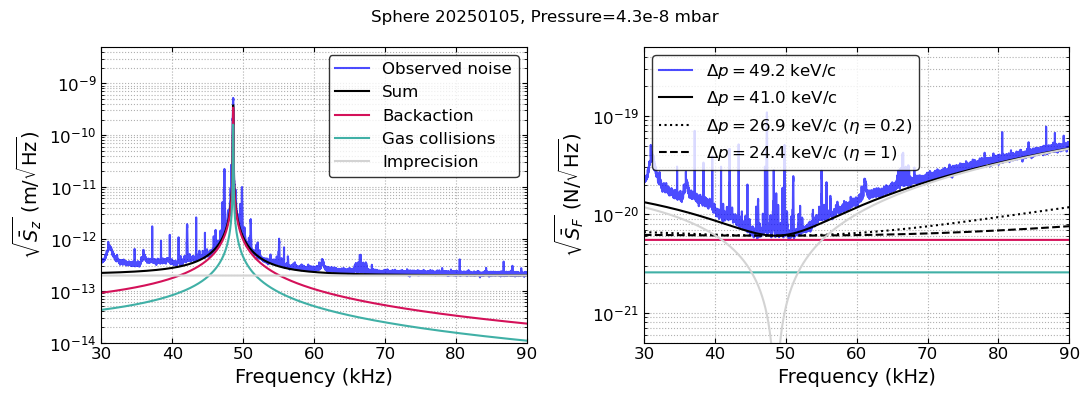

In [355]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

axes[0].plot(ff/1000, np.sqrt(sz_measured), color='b', label='Observed noise', alpha=0.7)
sz_sum = _s_ff_ba_reheating*2 * chi_2_convolved + _s_ff_th_reheating*2 * chi_2_convolved + sz_imp
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(sz_sum)), color='Black', linewidth=1.5, label='Sum')
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_ba_reheating*2 * chi_2_convolved)), color='#D41159', label='Backaction')
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_th_reheating*2 * chi_2_convolved)), color='#40B0A6', label='Gas collisions')
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(sz_imp)), color='lightgray', label='Imprecision')

int_band = (30000, 90000)
sf_sum = _s_ff_ba_reheating*2 + _s_ff_th_reheating*2 + sz_imp / chi_2_convolved
sf_sum_realistic_eta = _s_ff_ba_reheating*2 + _s_ff_th_reheating*2 + _s_zz_imp_reheating * 2 * 5 / chi_2_convolved
sf_sum_perfect_eta = _s_ff_ba_reheating*2 + _s_ff_th_reheating*2 + _s_zz_imp_reheating * 2 / chi_2_convolved

idx_int = np.logical_and(ff>int_band[0], ff<int_band[1])
dp_kev_model = np.sqrt( 1/( np.trapz(4/sf_sum[idx_int], x=ff[idx_int]*2*np.pi) /(2*np.pi) ) ) * SI2ev / 1000
dp_kev_model_realistic_eta = np.sqrt( 1/( np.trapz(4/sf_sum_realistic_eta[idx_int], x=ff[idx_int]*2*np.pi) /(2*np.pi) ) ) * SI2ev / 1000
dp_kev_model_perfect_eta = np.sqrt( 1/( np.trapz(4/sf_sum_perfect_eta[idx_int], x=ff[idx_int]*2*np.pi) /(2*np.pi) ) ) * SI2ev / 1000

axes[1].plot(ff/1000, np.sqrt(sf_measured), color='b', label=fr'$\Delta p = {dp_kev:.1f}$ keV/c', alpha=0.7)
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sf_sum)), color='Black', linewidth=1.5, label=fr'$\Delta p = {dp_kev_model:.1f}$ keV/c')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sf_sum_realistic_eta)), color='Black', linewidth=1.5, linestyle=':', label=fr'$\Delta p = {dp_kev_model_realistic_eta:.1f}$ keV/c ($\eta=0.2$)')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sf_sum_perfect_eta)), color='Black', linewidth=1.5, linestyle='--', label=fr'$\Delta p = {dp_kev_model_perfect_eta:.1f}$ keV/c ($\eta=1$)')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_ba_reheating*2)), '#D41159')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_th_reheating*2)), '#40B0A6')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sz_imp / chi_2_convolved)), color='lightgray')

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(30, 90)
    ax.set_xlabel('Frequency (kHz)')
axes[0].legend(edgecolor='k')
axes[1].legend(edgecolor='k')
axes[0].set_ylabel(r'$\sqrt{\bar{S}_{z}}$ (m/$\sqrt{\mathrm{Hz}}$)')
axes[1].set_ylabel(r'$\sqrt{\bar{S}_{F}}$ (N/$\sqrt{\mathrm{Hz}}$)')

axes[0].set_ylim(1e-14, 5e-9)
axes[1].set_ylim(5e-22, 5e-19)

axes[0].grid(linestyle=':', which='both')
axes[1].grid(linestyle=':', which='both')

fig.suptitle('Sphere 20250105, Pressure=4.3e-8 mbar', fontsize=12)
fig.align_labels()
fig.tight_layout()

#### Now repeat the process for data taken at 6e-8 mbar

In [332]:
sphere = 'sphere_20260105'
folder = '20260106_electric_calibration_6e-8mbar_0'

c_mvs_all = []
vpps = [0.5, 1, 1.5, 2]
for i, vpp in enumerate(vpps):
    file_prefix = rf'20260106_d_p8e_117khz_{vpp}vpp_lensholder1'
    _files = [rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_0.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_1.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_2.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_3.hdf5',
            rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/{file_prefix}_4.hdf5']

    c_mvs = utils.get_c_mv(_files, vp2p=[vpps[i], vpps[i], vpps[i], vpps[i], vpps[i]], omegad=117000*2*np.pi, passband=(116900, 117100), searchband=(45000, 55000), charge=8, n_chunk=1, efield=138, sphere_radius=50e-9)
    c_mvs_all.append(c_mvs)

c_mv = np.mean(np.asarray(c_mvs_all))
print(f'c_mv: {c_mv}')

c_mv: 3.5430512774102133e-07


Delta_p: 46.06197214317248 keV/c


(0.0, 120.0)

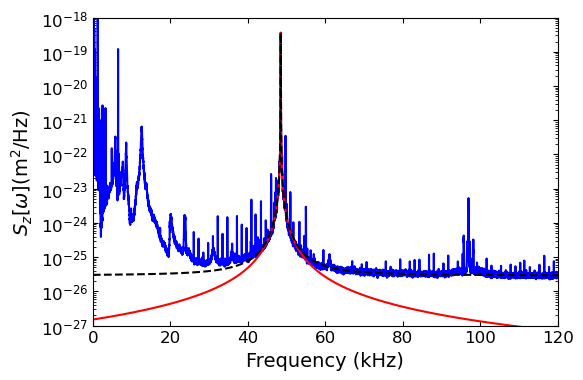

In [333]:
_file = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{folder}/20260106_d_p8e_nodrive_2.hdf5'
ff, sz_measured, sf_measured, chi_2_convolved, dp_kev, fig, ax, voigt = utils.get_effective_force_noise(_file, c_mv, int_band=(30000, 90000), 
                                                                                                        fit_band=(44000, 60000), nperseg=2**19, plot_fit=True,
                                                                                                        p0=[2e-19, 48381*2*np.pi, 100*2*np.pi, 5*2*np.pi])
print(f'Delta_p: {dp_kev} keV/c')

_idx = np.logical_and(ff>110000, ff<150000)
sz_imp = np.mean(sz_measured[_idx])

ax.plot(ff/1000, voigt+sz_imp, 'k--')
ax.set_ylim(1e-27, 1e-18)
ax.set_xlim(0, 120)

In [334]:
# Find the resonant frequency from the measured displacement noise
_idx = np.logical_and(ff>40000, ff<90000)
omega0 = ff[_idx][np.argmax(sz_measured[_idx])] * 2 * np.pi

In [335]:
gamma_reheating = 35833 * 2 * np.pi
gamma_reheating_gas = (5.8/2) * 2201 * 2 * np.pi / (100/166) # Data were taken at 4.3e-8 mbar compared to 2e-8 mbar

_s_ff_ba_reheating = gamma_reheating * (2 * m * omega0 * hbar)
_s_ff_th_reheating = gamma_reheating_gas * (2 * m * omega0 * hbar)
_s_zz_imp_reheating = (hbar**2 / 4) / _s_ff_ba_reheating

print(f'Backaction noise (double-sided, est. from reheating): {_s_ff_ba_reheating:.3e} N^2/Hz')
print(f'Thermal noise (double-sided, est. from reheating): {_s_ff_th_reheating:.3e} N^2/Hz')
print(f'Imprecision noise (double-sided, est. from reheating): {_s_zz_imp_reheating:.3e} m^2/Hz')

z_zpf = np.sqrt(hbar / (2 * m * omega0))
gamma_meas = z_zpf**2 / (2 * sz_imp) # 2 instead of 4 because `sz_imp` here is single-sided spectral density
eta_m = gamma_meas / (gamma_reheating + gamma_reheating_gas)
print(f'Measurement efficiency: {eta_m:.3f}')



Backaction noise (double-sided, est. from reheating): 1.514e-41 N^2/Hz
Thermal noise (double-sided, est. from reheating): 4.477e-42 N^2/Hz
Imprecision noise (double-sided, est. from reheating): 1.836e-28 m^2/Hz
Measurement efficiency: 0.010


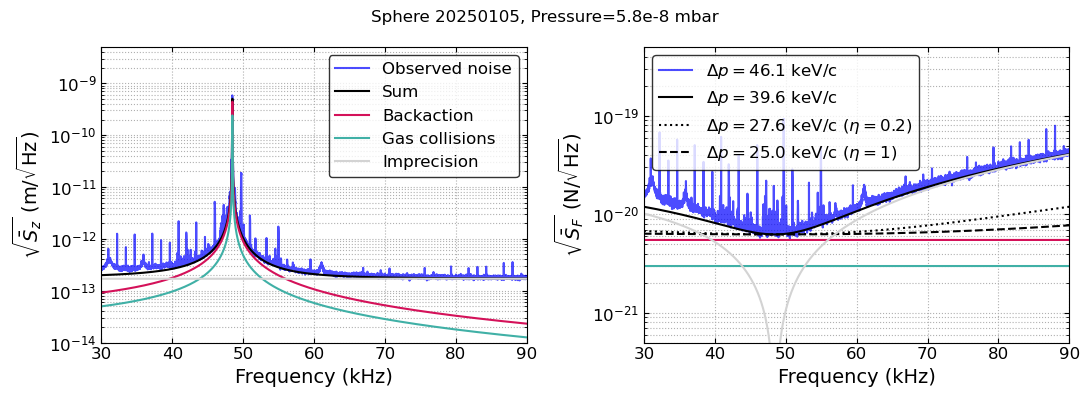

In [340]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

axes[0].plot(ff/1000, np.sqrt(sz_measured), color='b', label='Observed noise', alpha=0.7)
sz_sum = _s_ff_ba_reheating*2 * chi_2_convolved + _s_ff_th_reheating*2 * chi_2_convolved + sz_imp
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(sz_sum)), color='Black', linewidth=1.5, label='Sum')
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_ba_reheating*2 * chi_2_convolved)), color='#D41159', label='Backaction')
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_th_reheating*2 * chi_2_convolved)), color='#40B0A6', label='Gas collisions')
axes[0].plot(ff/1000, np.full_like(ff, np.sqrt(sz_imp)), color='lightgray', label='Imprecision')


int_band = (30000, 90000)
sf_sum = _s_ff_ba_reheating*2 + _s_ff_th_reheating*2 + sz_imp / chi_2_convolved
sf_sum_realistic_eta = _s_ff_ba_reheating*2 + _s_ff_th_reheating*2 + _s_zz_imp_reheating * 2 * 5 / chi_2_convolved
sf_sum_perfect_eta = _s_ff_ba_reheating*2 + _s_ff_th_reheating*2 + _s_zz_imp_reheating * 2 / chi_2_convolved

idx_int = np.logical_and(ff>int_band[0], ff<int_band[1])
dp_kev_model = np.sqrt( 1/( np.trapz(4/sf_sum[idx_int], x=ff[idx_int]*2*np.pi) /(2*np.pi) ) ) * SI2ev / 1000
dp_kev_model_realistic_eta = np.sqrt( 1/( np.trapz(4/sf_sum_realistic_eta[idx_int], x=ff[idx_int]*2*np.pi) /(2*np.pi) ) ) * SI2ev / 1000
dp_kev_model_perfect_eta = np.sqrt( 1/( np.trapz(4/sf_sum_perfect_eta[idx_int], x=ff[idx_int]*2*np.pi) /(2*np.pi) ) ) * SI2ev / 1000

axes[1].plot(ff/1000, np.sqrt(sf_measured), color='b', label=fr'$\Delta p = {dp_kev:.1f}$ keV/c', alpha=0.7)
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sf_sum)), color='Black', linewidth=1.5, label=fr'$\Delta p = {dp_kev_model:.1f}$ keV/c')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sf_sum_realistic_eta)), color='Black', linewidth=1.5, linestyle=':', label=fr'$\Delta p = {dp_kev_model_realistic_eta:.1f}$ keV/c ($\eta=0.2$)')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sf_sum_perfect_eta)), color='Black', linewidth=1.5, linestyle='--', label=fr'$\Delta p = {dp_kev_model_perfect_eta:.1f}$ keV/c ($\eta=1$)')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_ba_reheating*2)), '#D41159')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(_s_ff_th_reheating*2)), '#40B0A6')
axes[1].plot(ff/1000, np.full_like(ff, np.sqrt(sz_imp / chi_2_convolved)), color='lightgray')


for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(30, 90)
    ax.set_xlabel('Frequency (kHz)')
axes[0].legend(edgecolor='k', fontsize=12)
axes[1].legend(edgecolor='k', fontsize=12)
axes[0].set_ylabel(r'$\sqrt{\bar{S}_{z}}$ (m/$\sqrt{\mathrm{Hz}}$)')
axes[1].set_ylabel(r'$\sqrt{\bar{S}_{F}}$ (N/$\sqrt{\mathrm{Hz}}$)')

axes[0].set_ylim(1e-14, 5e-9)
axes[1].set_ylim(5e-22, 5e-19)

axes[0].grid(linestyle=':', which='both')
axes[1].grid(linestyle=':', which='both')

fig.suptitle('Sphere 20250105, Pressure=5.8e-8 mbar', fontsize=12)
fig.align_labels()
fig.tight_layout()